## Variables
#### Buses
* bus: ($ch_n, st_n, r_{n,m}, tb_{n,m}, sb_{n,m}$)
    * $ch_n$ - charging state of bus n
    * $st_n$ - state of bus n (3 states: deployed, not-deployed, charging/refueling)
    * $r_{n,m}$ - the route on which the bus is deployed
    * $tb_{n,m}$ - the previous stop the bus travelled to (travel time)
    * $sb_{n,m}$ - the previous stop which was served by the bus (service time)
        * If $tb_n$= $sb_n$, generate travel time for $tb_{n+1}$; $tb_n$ = $tb_{n+1}$ if accepted
        * Else if $tb_n$> $sb_n$, generate service time for $sb_{n+1}$; $sb_n$ = $sb_{n+1}$ if accepted
    * Arrival time - route generated arrays
    * Service Time - route generated arrays

___
### System State New
SS = (n_buses, curr_dem, buses_deployed, buses_recharge, buses_standstill)
SS = (n_buses, curr_dem, buses_deployed, buses_recharge, buses_standstill, route_1_buses, route_2_buses,....)

#### Monitoring System State 

| Time | System State | Bus | Charge | Route | State | Event | Process Time | Demand-Current | Demand-Actual | Demand-Charge |
| ---- | ------------ | --- | ------ | ----- | ----- | ----- | ------------ | -------------- | ------------- | ------------- |
| 0    | (1,1,1,0,0)  | 1   | 50     | '1'   | 1     | 0     | 0            | 0              | 0             | 15            |
| 10.3 | (1,0,1,0,0)  | 1   | 48     | '1'   | 1     | 1     | 10.3         | -              | -             | -             |
| 12.3 | (1,0,1,0,0)  | 1   | 47.5   | '1'   | 1     | 0     | 2.0          | -              | -             | -             |

___

#### Monitoring Bus Deployments

| Time | Demand-Current | Demand-Actual | Demand-Charge | Bus | Charge | Route | Event Array  | Time Array   |
| ---- | -------------- | ------------- | ------------- | --- | ------ | ----- | ------------ | ------------ |
| 0    | 0              | 0             | 15            | 1   | 50     | '1'   | [1, 0, 1]    | [12, 35, 41] |
| 40   | 41             | 40            | 20            | 1   | 35     | '2'   | [1, 0, 1]    | [48, 50, 55] |



In [1]:
import pandas as pd
import numpy as np
import numpy.random as random
from route_functions import *
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm 

# to ignore warning on calculations
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = r"C:\Users\krishrao\Desktop\Laptop Backup\Krishna\Fall'21\IOE 574\Term Project\IOE574_Project\data_files\LiqFuel_SensAnalysis\buses\\"
varred = pd.read_parquet(path+'bd_table_refill_10_60_0.071_0.061.parquet')

In [3]:
# intializing route table
routes = pd.read_excel('Model_Parameters.xlsx', 'Routes')

n_buses = 8                            # number of buses

# For liquid fuel buses
running_consumption = 0.071             # fuel(lts.)/kWh per minute
service_consumption = 0.061             # fuel(lts.)/kWh per minute
refuel_consumption = -30                # -30 for fuel, -2 for electric
tank_size = 150                         # 150 lts. / 240 kWh 
level_mean = 50                         # normal distribution.. can be changed
level_std = 0                           # currently constant at level_mean
refuel = 'refill'                       # 'refill', recharge'

'''
# For electric buses
running_consumption = 0.5              # fuel(lts.)/kWh per minute
service_consumption = 0.3              # fuel(lts.)/kWh per minute
refuel_consumption = -2                # -30 for fuel, -2 for electric
tank_size = 240                         # 150 lts. / 240 kWh 
level_mean = 80                         # normal distribution.. can be changed
level_std = 0                           # currently constant at level_mean
refuel = 'recharge'                     # 'refill', recharge'
'''

#-----
# customizable parameters
#average_bus_speed = 30 miles /hr
refuel_stations = 2
conversion_factor = 100/tank_size

# cost rates
emp_rate = 15                           # per hour basis
fuel_rate = 0.882                       # dollar 0.882 per lt. / 0.1275 per kWhr
delay_rate = 2.4                        # dollar per min ** reason
maintain_rate = 1.67                    # dollar per min 1.67 for fuel, 2.25 for elctric


# setting up initial values for simulation
n_routes = 4                            # number of routes
SimTime = 720

SS_cols = ['Time', 'System_State', 'Bus', 'Charge', 'Route', 
           'State', 'Event', 'Process_Time', 'Demand_Current', 
           'Demand_Actual', 'Demand_Charge']
BD_cols = ['Time', 'Demand_Current', 'Demand_Actual', 'Demand_Charge', 
           'Bus', 'Charge', 'Route', 'Event_Array', 'Time_Array']

In [4]:
replicates = int(varred['Replication'].max())
ss_table = pd.DataFrame(columns=SS_cols+['Replication'])
bd_table = pd.DataFrame(columns=BD_cols+['Replication'])

for i in range(replicates):
    print('-----\nRunning buses on Day ', i+1)                     # intializing required variabes
    event_array = list(varred['Event_Array'][(varred['Replication']==(i+1))&(varred['Route']!='refill')])
    time_array = list(varred['Time_Array'][(varred['Replication']==(i+1))&(varred['Route']!='refill')])

    # intializing required variabes
    buses = [bus(level_mean, level_std) for i in range(n_buses)]    # fleet of buses
    t = 0                                      # start time of simulation
    T = SimTime

    # updating demands
    demand_at, demand_r, demand_c = gen_demands(n_routes, T)
    demand_ct = demand_at.copy()         # demand current time and demand actual time
    dct_flag = 0                         # demand at current time

    ss_tab, bd_tab = fleet_simulation_varred(t, T, routes, event_array, time_array, buses, refuel, 
                                             running_consumption, service_consumption, refuel_stations, 
                                             refuel_consumption, conversion_factor, demand_at, demand_ct, 
                                             demand_r, demand_c, dct_flag, SS_cols, BD_cols)
    ss_tab['Replication'] = i+1
    bd_tab['Replication'] = i+1
    ss_table = ss_table.append(ss_tab, ignore_index=True)
    bd_table = bd_table.append(bd_tab, ignore_index=True)

-----
Running buses on Day  1
-----
Running buses on Day  2
-----
Running buses on Day  3
-----
Running buses on Day  4
-----
Running buses on Day  5
-----
Running buses on Day  6
-----
Running buses on Day  7
-----
Running buses on Day  8
-----
Running buses on Day  9
-----
Running buses on Day  10
-----
Running buses on Day  11
-----
Running buses on Day  12
-----
Running buses on Day  13
-----
Running buses on Day  14
-----
Running buses on Day  15
-----
Running buses on Day  16
-----
Running buses on Day  17
-----
Running buses on Day  18
-----
Running buses on Day  19
-----
Running buses on Day  20
-----
Running buses on Day  21
-----
Running buses on Day  22
-----
Running buses on Day  23
-----
Running buses on Day  24
-----
Running buses on Day  25
-----
Running buses on Day  26
-----
Running buses on Day  27
-----
Running buses on Day  28
-----
Running buses on Day  29
-----
Running buses on Day  30


ss_table

bd_table

varred

___
## Model Analysis

In [5]:
#del varred

# delay analysis on deployments
num_delay = sum(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])>0)
total_delay = sum(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])))
avg_delay = round(np.mean(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual']))), 3)
std_delay = round(np.std(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual']))), 3)
max_delay = max(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])))

# cost analysis
run_time, ser_time, ref_time, emp_cost, fuel_cost, delay_cost = cost_analysis(n_buses, replicates, refuel, ss_table, 
                                                                              bd_table, emp_rate, fuel_rate, delay_rate, 
                                                                              refuel_consumption)

# convergence on delays
beta = 1.5
alpha = 0.05
ci_n = 1-alpha/2    
n_beta = (st.t.ppf(ci_n, df=replicates-1)*std_delay
          /np.sqrt(replicates))

print('---\nCurrent half-width - ', round(n_beta, 3), 'min')
print('Current replications -', replicates)
print('Number of bus deployments -', bd_table.shape[0])

if n_beta > beta:
    s2_n =  (std_delay)**2
    t = st.t.ppf(ci_n, df=replicates-1)
    n_rep = int((t*np.sqrt(s2_n)/beta)**2) + 1
    n_rep = int(n_rep*replicates/replicates) + 1
    print('The extra replications to be done - ', n_rep-replicates)
    
'''
while n_beta > beta:
    s2_n =  (std_delay)**2
    t = st.t.ppf(ci_n, df=replicates-1)
    n_rep = int((t*np.sqrt(s2_n)/beta)**2) + 1
    n_rep = int(n_rep*replicates/replicates) + 1
    print('The extra replications to be done - ', n_rep-replicates)
    
    for h in range(replicates, n_rep):
        print('-----\nRunning buses on Day ', h+1)                     # intializing required variabes
        buses = [bus(level_mean, level_std) for i in range(n_buses)]   # fleet of buses
        t = 0                                                          # start time of simulation
        T = SimTime
        demand_at, demand_r, demand_c = gen_demands(n_routes, T)     # updating demands
        demand_ct = demand_at.copy()                                 # demand current time and demand actual time
        dct_flag = 0                                                 # demand at current time
        ss_tab, bd_tab = fleet_simulation(t, T, routes, buses, refuel, running_consumption, 
                                          service_consumption, refuel_stations, refuel_consumption, conversion_factor,
                                          demand_at, demand_ct, demand_r, demand_c, dct_flag, SS_cols, BD_cols)
        ss_tab['Replication'] = h + 1
        bd_tab['Replication'] = h + 1
        ss_table = ss_table.append(ss_tab, ignore_index=True)
        bd_table = bd_table.append(bd_tab, ignore_index=True)
        
    replicates = n_rep
    n_beta = (st.t.ppf(ci_n, df=replicates-1)*std_delay/np.sqrt(replicates))
    print('---\nThe new half-width', round(n_beta, 3), 'min')
    print('Current replications -', replicates)
    print('Number of bus deployments -', bd_table.shape[0])
'''
#.

---
Current half-width -  1.948 min
Current replications - 30
Number of bus deployments - 4108
The extra replications to be done -  22


"\nwhile n_beta > beta:\n    s2_n =  (std_delay)**2\n    t = st.t.ppf(ci_n, df=replicates-1)\n    n_rep = int((t*np.sqrt(s2_n)/beta)**2) + 1\n    n_rep = int(n_rep*replicates/replicates) + 1\n    print('The extra replications to be done - ', n_rep-replicates)\n    \n    for h in range(replicates, n_rep):\n        print('-----\nRunning buses on Day ', h+1)                     # intializing required variabes\n        buses = [bus(level_mean, level_std) for i in range(n_buses)]   # fleet of buses\n        t = 0                                                          # start time of simulation\n        T = SimTime\n        demand_at, demand_r, demand_c = gen_demands(n_routes, T)     # updating demands\n        demand_ct = demand_at.copy()                                 # demand current time and demand actual time\n        dct_flag = 0                                                 # demand at current time\n        ss_tab, bd_tab = fleet_simulation(t, T, routes, buses, refuel, running_co

In [6]:
# delay analysis on deployments
num_delay = sum(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])>0)
total_delay = sum(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])))
avg_delay = round(np.mean(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual']))), 3)
std_delay = round(np.std(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual']))), 3)
max_delay = max(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])))

# cost analysis
run_time, ser_time, ref_time, emp_cost, fuel_cost, delay_cost = cost_analysis(n_buses, replicates, refuel, ss_table, 
                                                                              bd_table, emp_rate, fuel_rate, delay_rate, 
                                                                              refuel_consumption)

In [7]:
print('Delay Analyis')
print('\tTotal number of replications (days) -', replicates)
print('\tTotal number of delays -', num_delay)
print('\tTotal delay in minutes -', round(total_delay, 2))
print('\tAverage of delay events in minutes -', round(total_delay/num_delay, 2))

print('\n\tAverage delay (all events) in minutes -', round(avg_delay, 2))
print('\tStd. Deviation of delay (all events) in minutes -', round(std_delay, 2))
print('\tMaximum delay (all events) in minutes -', round(max_delay, 2))


print('\n\tTotal number of deployments -', bd_table.shape[0])
print('\tTotal number of route deployments -', sum(bd_table['Route']!=refuel))
print('\tTotal number of refills deployments -', sum(bd_table['Route']==refuel))

print('\n\nCost Analysis')
print('\tAverage running time for all buses per day in minutes -', run_time)
print('\tAverage service time for all buses per day in minutes -', ser_time)
print('\tAverage refuel time for all buses per day in minutes -', ref_time)

print('\n\tAverage employeee costs paid per day in dollars -', emp_cost)
print('\tAverage fuel costs paid per day in dollars -', fuel_cost)
print('\tAverage delay costs paid per day in dollars -', delay_cost)
print('\tAverage maintenance costs paid per day in dollars -', round(maintain_rate*(run_time+ser_time+ref_time)))

Delay Analyis
	Total number of replications (days) - 30
	Total number of delays - 2449
	Total delay in minutes - 19350.45
	Average of delay events in minutes - 7.9

	Average delay (all events) in minutes - 4.71
	Std. Deviation of delay (all events) in minutes - 5.22
	Maximum delay (all events) in minutes - 24.59

	Total number of deployments - 4108
	Total number of route deployments - 3870
	Total number of refills deployments - 238


Cost Analysis
	Average running time for all buses per day in minutes - 3588.35
	Average service time for all buses per day in minutes - 1513.22
	Average refuel time for all buses per day in minutes - 21.68

	Average employeee costs paid per day in dollars - 1281
	Average fuel costs paid per day in dollars - 574
	Average delay costs paid per day in dollars - 46441
	Average maintenance costs paid per day in dollars - 8556


In [8]:
# Charge distribution
ss_table['Charge'].min(), ss_table['Charge'].max()

(22.258, 95.547)

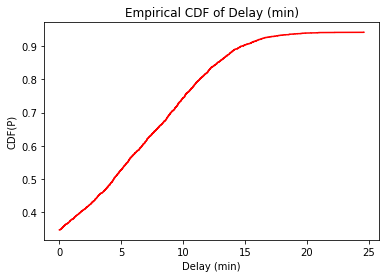

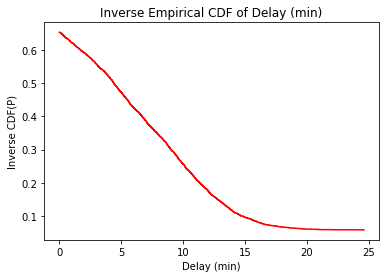

In [9]:
delay_arr = np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])
ecdf(delay_arr, 'Delay (min)')
inv_ecdf(delay_arr, 'Delay (min)')

In [10]:
ss_table.to_parquet(path+'ss_table_'+refuel+'_'+np.str(n_buses)+'_'+
                    np.str(level_mean)+'_'+np.str(running_consumption)+'_'+
                    np.str(service_consumption)+'.parquet')
bd_table.to_parquet(path+'bd_table_'+refuel+'_'+np.str(n_buses)+'_'+
                    np.str(level_mean)+'_'+np.str(running_consumption)+'_'+
                    np.str(service_consumption)+'.parquet')